# Mines Data Exploration
## Table of Contents
<ul>
    <li><a href='#preliminary_wrangling'>Preliminary Wrangling</a></li>
    <ul>
        <li><a href='#structure_of_dataset'>Structure of Dataset</a></li>
        <li><a href='#features_of_interest'>Feature of Interest</a></li>
        <li><a href='#thoughts_for_investigating'>Thoughts for Investigating</a></li>     
    </ul>
</ul>
    

<a id='preliminary_wrangling'></a>
## Preliminary Wrangling

This section preliminary explores a mine dataset that lists all Coal and Metal/Non-Metal mines under MSHA's jurisdiction since 1/1/1970.

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import os
import requests

%matplotlib inline

In [3]:
# load in the dataset into a pandas dataframe
mines = pd.read_csv('mines.txt', sep='|', encoding='ISO-8859-1')

In [4]:
# download column definitions and save
url = 'https://arlweb.msha.gov/OpenGovernmentData/DataSets/Mines_Definition_File.txt'
definition_file_name = url.split('/')[-1]

if not os.path.exists(definition_file_name):
    response = requests.get(url)
    with open(os.path.join(definition_file_name),
              mode = 'wb') as file:
        file.write(response.content)

In [5]:
# high-level overview overview of mine data shape and composition
print(mines.shape)
print(mines.info())
mines.head()

(87596, 59)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87596 entries, 0 to 87595
Data columns (total 59 columns):
MINE_ID                        87596 non-null int64
CURRENT_MINE_NAME              87596 non-null object
COAL_METAL_IND                 87596 non-null object
CURRENT_MINE_TYPE              87249 non-null object
CURRENT_MINE_STATUS            87596 non-null object
CURRENT_STATUS_DT              87596 non-null object
CURRENT_CONTROLLER_ID          86558 non-null object
CURRENT_CONTROLLER_NAME        86558 non-null object
CURRENT_OPERATOR_ID            86843 non-null object
CURRENT_OPERATOR_NAME          87596 non-null object
STATE                          87596 non-null object
BOM_STATE_CD                   87596 non-null int64
FIPS_CNTY_CD                   87596 non-null int64
FIPS_CNTY_NM                   87596 non-null object
CONG_DIST_CD                   68869 non-null float64
COMPANY_TYPE                   86843 non-null object
CURRENT_CONTROLLER_BEGIN_DT    86

,MINE_ID,CURRENT_MINE_NAME,COAL_METAL_IND,CURRENT_MINE_TYPE,CURRENT_MINE_STATUS,CURRENT_STATUS_DT,CURRENT_CONTROLLER_ID,CURRENT_CONTROLLER_NAME,CURRENT_OPERATOR_ID,CURRENT_OPERATOR_NAME,...,NO_NONPRODUCING_PITS,NO_TAILING_PONDS,PILLAR_RECOVERY_USED,HIGHWALL_MINER_USED,MULTIPLE_PITS,MINERS_REP_IND,SAFETY_COMMITTEE_IND,MILES_FROM_OFFICE,DIRECTIONS_TO_MINE,NEAREST_TOWN
0,100003,O'Neal Quarry & Mill,M,Surface,Active,01/22/1979,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",...,NaN,0.0,N,N,N,N,N,100,Approx 7 miles south of the city of Alabaster ...,Calera
1,100004,Brierfield Quarry,M,Surface,Active,03/04/2003,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",...,NaN,0.0,N,N,N,N,N,35,"I-65 SOUTH EXIT US 31 TO CALERA, TURN RIGHT ON...",Brierfield
2,100005,Birmingham Plant,M,Surface,Abandoned,08/15/1989,0041044,Lhoist Group,L10998,Allied Lime Company,...,NaN,NaN,N,N,N,N,N,0,NaN,NaN
3,100006,Auburn Quarry,M,Surface,Active,09/24/1976,NaN,NaN,L16197,"Martin Marietta Materials, Inc.",...,NaN,0.0,N,N,N,N,N,140,85 to Hwy. 29 South to County Rd. 10; turn lef...,Auburn
4,100008,Landmark Plant,M,Surface,Active,11/14/1975,M31753,Alan B Cheney,L31753,Cheney Lime & Cement Company,...,NaN,0.0,N,N,N,N,N,25,I-65 S to exit 238; right on Hwy 31 1/8 miles ...,Alabaster


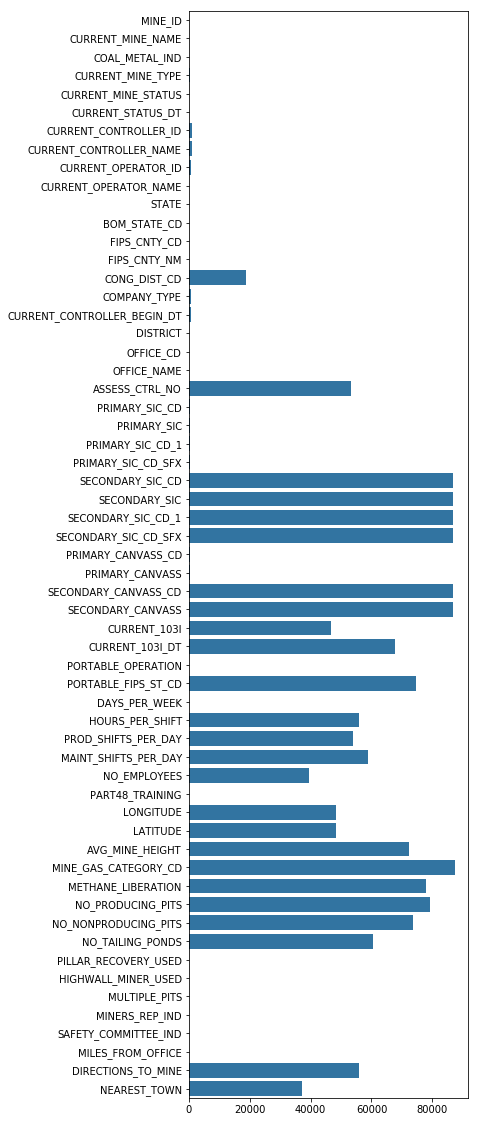

In [7]:
# visualize missing data
plt.figure(figsize=(5,20))
na_counts = mines.isna().sum()
base_color = sb.color_palette()[0]
sb.barplot(na_counts, na_counts.index.values,
           color=base_color);

<a id='structure_of_dataset'></a>
#### Structure of the dataset
There are 87,596 mines in the dataset. Each mine has 59 attributes. From first glance, it seems like not all variables can be used for the analysis. There's about an even balance between numeric and string variables. About half of variables have a lot of missing information. A number of mines have geo location. Upon further look into the columns with missing values along with a definition table for mine variables, a logical reason comes out why a lot of values are missing. Here's the logic:
- CURRENT_CONTROLLER_ID, CURRENT_OPERATOR_ID, CURRENT_OPERATOR_ID: If it's a new mine, current controllers and operators may not have been assigned yet.
- ASSESS_CTRL_NO: the most recent violation or citation and this may not have been tracked at older dates. Also, some newer mines may not have gotten any violations yet.
- SECONDARY_SIC_CD, SECONDARY_SIC, SECONDARY_SIC_CD_1, SECONDARY_SIC_CD_SFX: Not all mines mine more than one resource. Same with having more than one canvas.
- PORTABLE_FIPS_ST_CD: applies only to portable mines.
- AVG_MINE_HEIGHT: applies to coal mines only, but it's still has missing values.
- MINE_GAS_CATEGORY_CD: doesn't apply to all mines. Only for Metal/Non-Metal mines and the surface mills of Subcategory I-C mines (gilsonite) mines.
- METHANE_LIBERATION, NO_PRODUCING_PITS, NO_NONPRODUCING_PITS, NO_TAILING_PONDS: may not apply to all mines.


And there're columns that really have null values. My guess is that it's due to those values not being tracked in earlier years or regulations being less strict. This is something that would be interesting to investigate with data. These columns are:
- CURRENT_103I
- CURRENT_103I_DT
- HOURS_PER_SHIFT
- PROD_SHIFTS_PER_DAY
- MAINT_SHIFTS_PER_DAY
- NO_EMPLOYEES
- LONGITUDE and LATITUDE
- AVG_MINE_HEIGHT
- NO_PRODUCING_PITS
- NO_NONPRODUCING_PITS
- NO_TAILING_PONDS
- DIRECTIONS_TO_MINE
- NEAREST_TOWN

<a id='features_of_interest'></a>
#### Features of interest in the dataset
This dataset spans 47 years. I'm interested in three things. 
1. Have the mine safety and conditions improved in any way since MSHA started regulating mines in the US?
2. How have resources mined and type of mines changed over this period of time? Or maybe nothing changed?
3. What are the summarry statistics of mines that are currently active?

<a id='thoughts_for_investigating'></a>
#### Thoughts for investigating the dataset
For the first question, I expect to find jumps or changes in variables when looked over the years. I think number of accidents and violations will drop. Also, as time progresses I expect metric to be tracked more consistently and to see less null values. 

For the second question, I expect less coal mines in later years. I'm not sure what to expect with metal/non-metal mines.

For the third question,  think the most interesting would be to see distribution of people employed in mining and locations of different type of mines.